In [101]:
import pandas as pd

# Load the data into a pandas DataFrame
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Ensure 'Settlement Point Price' and 'QUANTITY' are treated as numeric columns.
# Coerce any errors during conversion to NaN, which will be handled during the filling process.
# Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
data.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order 
data.sort_index(inplace=True)

# Resample the data to hourly frequency, aggregating with the mean
# Only numeric columns should be included in this operation.

# Should not Average the Data here, they are separate datasets
account_b_data = data[data["ACCOUNT_NUMBER"] == "account_b"][['Settlement_Point_Price', 'QUANTITY']]
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"][['Settlement_Point_Price', 'QUANTITY']]

account_b_data = account_b_data.dropna()
account_a_data = account_a_data.dropna()


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Scale your data using MinMaxScaler to help the LSTM converge faster
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(account_a_data[['QUANTITY']].values)

# Convert the dataset into sequences of a specific window size
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Define the sequence length (number of time steps to look back) and create sequences
seq_length = 4
x, y = sliding_windows(data_scaled, seq_length)

# Convert to PyTorch tensors
dataX = torch.Tensor(x)
dataY = torch.Tensor(y)

# Define the number of splits for cross-validation
n_splits = 4  # For example, you can choose 4-fold cross-validation

# TimeSeriesSplit provides train/test indices to split time series data samples
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(dataX)):
    # Create training and testing sets for this fold
    trainX, trainY = dataX[train_index], dataY[train_index]
    testX, testY = dataX[test_index], dataY[test_index]
    
    # Create DataLoader instances for training and testing sets
    batch_size = 64  # You can adjust the batch size
    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(testX, testY)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
import torch.nn as nn

# Define the LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

The LSTM class is defined with parameters for input size, hidden size, output size, and the number of layers.
The forward method initializes the hidden state h0 and cell state c0 with zeros for each batch, ensuring they are on the same device as the input tensor x.
The LSTM output out is passed through a fully connected layer to produce the final output.
The hidden and cell states are detached from the graph after each batch to prevent backpropagation through the entire sequence of states (which is not needed and would significantly increase memory usage).

In [94]:
import torch

# Model initialization and training configuration
num_epochs = 1000
learning_rate = 0.01

input_size = 1  # This should match the last dimension of your input data
hidden_size = 50
num_layers = 1

output_size = 1  # Since you are predicting a single value

# Instantiate the model
lstm = LSTM(input_size, hidden_size, output_size, num_layers)
lstm = lstm.cuda()  # Ensure model is on CUDA

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lstm.train()  # Set model to training mode
    total_loss = 0

    for seq, labels in train_loader:
        # Move data to CUDA
        seq, labels = seq.cuda(), labels.cuda()
        #print(f"Input shape: {seq.shape}")  # Add this line to check input shape
        #outputs = lstm(seq)
        # Forward pass
        outputs = lstm(seq)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 100 == 0:  # Print average loss every 100 epochs
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# After training, you might want to save your model
# torch.save(lstm.state_dict(), 'lstm_model.pth')

# Evaluation
lstm.eval()  # Set model to evaluation mode
test_losses = []
with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.cuda(), labels.cuda()
        outputs = lstm(seq)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')

Epoch [0/1000], Loss: 0.0336
Epoch [100/1000], Loss: 0.0167
Epoch [200/1000], Loss: 0.0150
Epoch [300/1000], Loss: 0.0135
Epoch [400/1000], Loss: 0.0123
Epoch [500/1000], Loss: 0.0112
Epoch [600/1000], Loss: 0.0102
Epoch [700/1000], Loss: 0.0095
Epoch [800/1000], Loss: 0.0090
Epoch [900/1000], Loss: 0.0086
Average Test Loss: 0.0444


In [2]:
from matplotlib import pyplot as plt
#load the model
lstm = LSTM(input_size, hidden_size, output_size, num_layers)
lstm.load_state_dict(torch.load('lstm_model_state_dict.pth'))
# Assuming lstm, trainX, testX are defined and loaded with the correct data
lstm.eval()  # Set the model to evaluation mode

# Generate predictions for both training and test sets
train_predict = lstm(trainX.cuda())
test_predict = lstm(testX.cuda())

# Concatenate train and test predictions for full data visualization
full_predict = torch.cat((train_predict, test_predict), 0)

# Inverse transform the predictions and actual data
data_predict = scaler.inverse_transform(full_predict.data.cpu().numpy())
dataY_plot = scaler.inverse_transform(dataY.data.cpu().numpy())

# Calculate the splitting point in the plot for visualizing train-test separation
split_pt = trainX.size(0) + seq_length  # Account for the sequence length

# Plotting
plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')

# Actual data
plt.plot(dataY_plot, label='Actual Data')

# Predictions (overlay on the actual data)
plt.plot(np.arange(seq_length, len(data_predict)+seq_length), data_predict, label='Predicted Data')

plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

NameError: name 'LSTM' is not defined

In [1]:
#Plotting the chart for date range 0-2000
plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')
plt.plot(dataY_plot[:2000], label='Actual Data')
plt.plot(np.arange(seq_length, 2000+seq_length), data_predict[:2000], label='Predicted Data')
plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [93]:
# Calculate the mean squared error
mse = np.mean(np.square(dataY_plot - data_predict))
print("Mean Squared Error: %1.5f" % mse)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)

Mean Squared Error: 2.49443
Root Mean Squared Error: 1.57938


In [23]:
# Save the model's state dictionary
torch.save(lstm.state_dict(), 'lstm_model_state_dict.pth')

# Predict Price without Weather data

In [106]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the data
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Convert 'Settlement Point Price' and 'QUANTITY' to numeric and handle errors
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index and sort the DataFrame
data.set_index('DateTime', inplace=True)
data.sort_index(inplace=True)

# Filter out the data for account A and B, and drop NA values
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"][['Settlement_Point_Price']].dropna()
account_b_data = data[data["ACCOUNT_NUMBER"] == "account_b"][['Settlement_Point_Price']].dropna()

In [109]:
# Normalize the price data for account A
scaler_a = MinMaxScaler(feature_range=(-1, 1))
scaled_prices_a = scaler_a.fit_transform(account_a_data.values.reshape(-1, 1))

# Convert the data to sequences for account A
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 4  # Number of time steps to look back
X_a, y_a = create_sequences(scaled_prices_a, seq_length)

# Split the data into training and test sets for account A
train_size_a = int(len(y_a) * 0.67)
test_size_a = len(y_a) - train_size_a

X_train_a, y_train_a = X_a[:train_size_a], y_a[:train_size_a]
X_test_a, y_test_a = X_a[train_size_a:], y_a[train_size_a:]

# Convert to PyTorch tensors for account A
X_train_tensor_a = torch.tensor(X_train_a, dtype=torch.float32)
y_train_tensor_a = torch.tensor(y_train_a, dtype=torch.float32)
X_test_tensor_a = torch.tensor(X_test_a, dtype=torch.float32)
y_test_tensor_a = torch.tensor(y_test_a, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for account A
train_dataset_a = TensorDataset(X_train_tensor_a, y_train_tensor_a)
train_loader_a = DataLoader(train_dataset_a, batch_size=64, shuffle=True)

test_dataset_a = TensorDataset(X_test_tensor_a, y_test_tensor_a)
test_loader_a = DataLoader(test_dataset_a, batch_size=64, shuffle=False)

# Normalize the price data for account B
scaler_b = MinMaxScaler(feature_range=(-1, 1))
scaled_prices_b = scaler_b.fit_transform(account_b_data.values.reshape(-1, 1))

# Convert the data to sequences for account B
X_b, y_b = create_sequences(scaled_prices_b, seq_length)

# Split the data into training and test sets for account B
train_size_b = int(len(y_b) * 0.67)
test_size_b = len(y_b) - train_size_b

X_train_b, y_train_b = X_b[:train_size_b], y_b[:train_size_b]
X_test_b, y_test_b = X_b[train_size_b:], y_b[train_size_b:]

# Convert to PyTorch tensors for account B
X_train_tensor_b = torch.tensor(X_train_b, dtype=torch.float32)
y_train_tensor_b = torch.tensor(y_train_b, dtype=torch.float32)
X_test_tensor_b = torch.tensor(X_test_b, dtype=torch.float32)
y_test_tensor_b = torch.tensor(y_test_b, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for account B
train_dataset_b = TensorDataset(X_train_tensor_b, y_train_tensor_b)
train_loader_b = DataLoader(train_dataset_b, batch_size=64, shuffle=True)

test_dataset_b = TensorDataset(X_test_tensor_b, y_test_tensor_b)
test_loader_b = DataLoader(test_dataset_b, batch_size=64, shuffle=False)


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [114]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Model parameters
input_size = 1  # As we have one feature, the scaled price
hidden_size = 50  # Number of features in the hidden state
num_layers = 1  # One-layer LSTM
output_size = 1  # As we want to predict one value at a time

# Instantiate the model
lstm_b = LSTM(input_size, hidden_size, num_layers, output_size)
lstm_b = lstm_b.cuda()  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_b.parameters(), lr=0.001)

# Train the model
num_epochs = 1000  # You can adjust the number of epochs
lstm_b.train()  # Set model to training mode

for epoch in range(num_epochs):
    total_loss = 0
    for sequences, prices in train_loader_b:
        sequences, prices = sequences.cuda(), prices.cuda()
        optimizer.zero_grad()  # Clear gradients
        outputs = lstm_b(sequences)  # Forward pass
        loss = criterion(outputs, prices)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        total_loss += loss.item()

    # Print average loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(train_loader_b):.4f}')

# Save the model after training
torch.save(lstm_b.state_dict(), 'lstm_model_price.pth')

# Evaluation
lstm_b.eval()  # Set the model to evaluation mode
test_losses = []
with torch.no_grad():
    for sequences, prices in test_loader_b:
        sequences, prices = sequences.cuda(), prices.cuda()
        outputs = lstm_b(sequences)
        loss = criterion(outputs, prices)
        test_losses.append(loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss for Account B: {average_test_loss:.4f}')

Epoch [0/1000], Loss: 0.1504
Epoch [100/1000], Loss: 0.0022
Epoch [200/1000], Loss: 0.0014
Epoch [300/1000], Loss: 0.0013
Epoch [400/1000], Loss: 0.0012
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0007
Epoch [800/1000], Loss: 0.0006
Epoch [900/1000], Loss: 0.0006
Average Test Loss for Account B: 0.0012


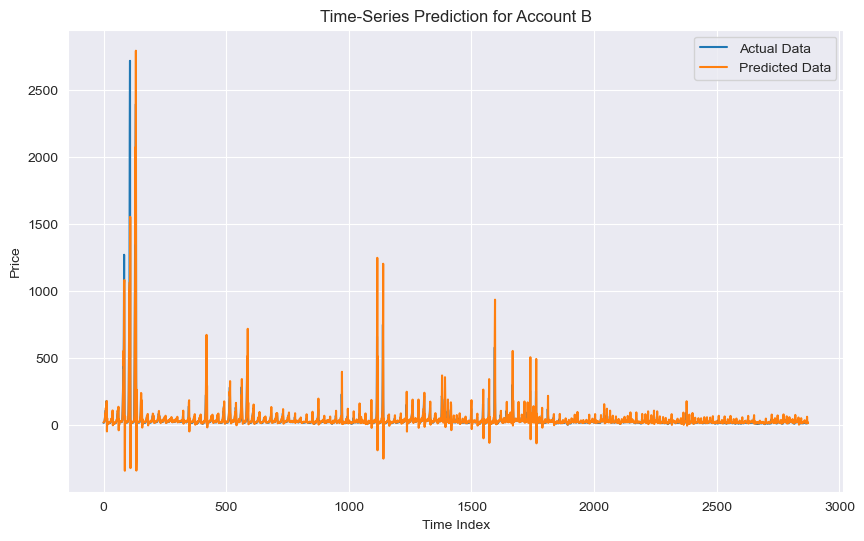

In [121]:
# Plot the predictions
lstm_b.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Generate predictions for the test set
    test_predict_b = lstm_b(X_test_tensor_b.cuda())
    # Inverse transform the predictions and actual data
    data_predict_b = scaler_b.inverse_transform(test_predict_b.cpu().numpy())
    dataY_plot_b = scaler_b.inverse_transform(y_test_tensor_b.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(10,6))
    plt.plot(dataY_plot_b, label='Actual Data')
    plt.plot(data_predict_b, label='Predicted Data')
    plt.title('Time-Series Prediction for Account B')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [122]:
# save the model's state dictionary
torch.save(lstm_b.state_dict(), 'lstm_model_state_dict_b_price.pth')
# RMS Error
mse = np.mean(np.square(dataY_plot_b - data_predict_b))
# Calculate the root mean squared error
rmse_b = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)

Root Mean Squared Error: 76.82786


In [118]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Assuming LSTM class is already defined as provided before
# Assuming create_sequences, MinMaxScaler, DataLoader, and TensorDataset are already imported

# Model parameters for Account A
input_size_a = 1  # As we have one feature, the scaled price
hidden_size_a = 50  # Number of features in the hidden state
num_layers_a = 1  # One-layer LSTM
output_size_a = 1  # As we want to predict one value at a time

# Instantiate the model for Account A
lstm_a = LSTM(input_size_a, hidden_size_a, num_layers_a, output_size_a)
lstm_a = lstm_a.cuda()  # Move model to GPU

# Loss and optimizer for Account A
criterion_a = nn.MSELoss()
optimizer_a = torch.optim.Adam(lstm_a.parameters(), lr=0.001)

# Train the model for Account A
num_epochs_a = 1000  # You can adjust the number of epochs
lstm_a.train()  # Set model to training mode

for epoch in range(num_epochs_a):
    total_loss_a = 0
    for sequences_a, prices_a in train_loader_a:
        sequences_a, prices_a = sequences_a.cuda(), prices_a.cuda()
        optimizer_a.zero_grad()  # Clear gradients
        outputs_a = lstm_a(sequences_a)  # Forward pass
        loss_a = criterion_a(outputs_a, prices_a)  # Compute loss
        loss_a.backward()  # Backward pass
        optimizer_a.step()  # Update weights
        total_loss_a += loss_a.item()

    # Print average loss every 100 epochs for Account A
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs_a}], Loss: {total_loss_a/len(train_loader_a):.4f}')

# Save the model after training for Account A
torch.save(lstm_a.state_dict(), 'lstm_model_price_account_a.pth')

# Evaluation for Account A
lstm_a.eval()  # Set the model to evaluation mode
test_losses_a = []
with torch.no_grad():
    for sequences_a, prices_a in test_loader_a:
        sequences_a, prices_a = sequences_a.cuda(), prices_a.cuda()
        outputs_a = lstm_a(sequences_a)
        loss_a = criterion_a(outputs_a, prices_a)
        test_losses_a.append(loss_a.item())

average_test_loss_a = sum(test_losses_a) / len(test_losses_a)
print(f'Average Test Loss for Account A: {average_test_loss_a:.4f}')


Epoch [0/1000], Loss: 0.1499
Epoch [100/1000], Loss: 0.0023
Epoch [200/1000], Loss: 0.0014
Epoch [300/1000], Loss: 0.0013
Epoch [400/1000], Loss: 0.0013
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0007
Epoch [800/1000], Loss: 0.0006
Epoch [900/1000], Loss: 0.0006
Average Test Loss for Account A: 0.0013


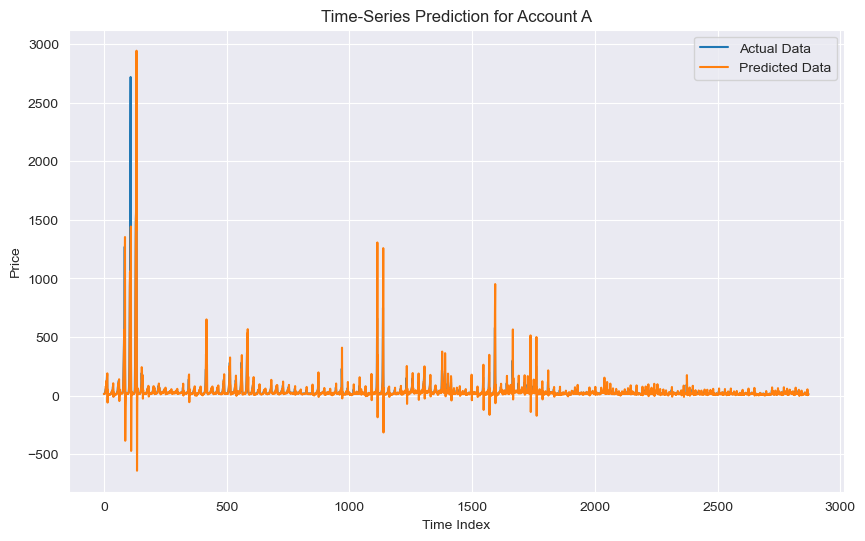

Root Mean Squared Error: 76.82786


In [120]:
# Plot the predictions for Account A
lstm_a.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Generate predictions for the test set
    test_predict_a = lstm_a(X_test_tensor_a.cuda())
    # Inverse transform the predictions and actual data
    data_predict_a = scaler_a.inverse_transform(test_predict_a.cpu().numpy())
    dataY_plot_a = scaler_a.inverse_transform(y_test_tensor_a.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(10,6))
    plt.plot(dataY_plot_a, label='Actual Data')
    plt.plot(data_predict_a, label='Predicted Data')
    plt.title('Time-Series Prediction for Account A')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
# RMS Error
mse = np.mean(np.square(dataY_plot_a - data_predict_a))
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)

# Predict Price with Weather data

Import Related Libraries

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

Load in and merge weather data

In [42]:
# Load in Weather and IGS data
igs_data = pd.read_csv("updated_igs_data.csv", index_col = 0)
hourly_weather = pd.read_csv("houston_hourly_weather_data.csv")

# Merge Data
hourly_weather["datetime"] = pd.to_datetime(hourly_weather["datetime"])
igs_data["LOCAL_FROM_DATETIME"] = pd.to_datetime(igs_data["LOCAL_FROM_DATETIME"])
price_df = igs_data.merge(hourly_weather, how = "left", left_on = "LOCAL_FROM_DATETIME", right_on = "datetime")

Clean Merged Data

In [43]:
# Rename and Add Columns
price_df.rename(columns = {"Delivery Date":"DateTime"}, inplace = True)
price_df["Month_Int"] = price_df["LOCAL_FROM_DATETIME"].apply(lambda d: d.month)

#Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
price_df['Settlement_Point_Price'] = pd.to_numeric(price_df['Settlement Point Price'], errors='coerce')
price_df['QUANTITY'] = pd.to_numeric(price_df['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
price_df.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
price_df.sort_index(inplace=True)

# Prices are the same for each account, so we can take prices from a single account
price_df = price_df[price_df["ACCOUNT_NUMBER"] == "account_a"][["Settlement_Point_Price", "Month_Int", "Hour", "Holiday", "Day", "Weekend", "temp"]]
price_df = price_df.dropna()

# Change Boolean values to floats
price_df = price_df.astype(float)

Function to create sequences of data

In [83]:
def create_sequences(data, seq_length, target_column_index=0):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length, target_column_index]
        xs.append(x)
        ys.append(y)

    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32).view(-1, 1)

Our LSTM Model Architecture:

In [84]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Apply dropout only if num_layers > 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x_time):
        # Initialize hidden and cell states with the correct device
        h_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(x_time.device)
        c_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(x_time.device)

        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x_time, (h_0, c_0))
        # Pass the output of the last time step through the dropout and fc layers
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)

        return out

Dataset Initialization

In [86]:
# Create Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# First, ensure your DataFrame's index is a DatetimeIndex
price_df.index = pd.to_datetime(price_df.index)

# Now you can extract the day of the month
days = price_df.index.day
# Assuming price_df has more than 2 columns, and we're only interested in two of them
# Let's extract only the Settlement_Point_Price and temp columns
selected_features = price_df[['Settlement_Point_Price', 'temp']].values

# Now we can create our sequences with only those two features
seq_length = 72  # Adjust this if needed
X, Y = create_sequences(selected_features, seq_length)

# Now, let's update the train/test split logic
# Assuming we have a column 'Day' in the original price_df to determine the days of the month
days = price_df.index.day  # Extracting the day of the month from the index of price_df
val_days = days[seq_length:]  # Adjusting for the sequence length offset

# Conditions for validation and training based on the day of the month
val_condition = val_days >= 25
train_condition = (val_days > 3) & (val_days < 25)

# Apply the conditions to the sequences
X_train = X[train_condition]
Y_train = Y[train_condition]
X_test = X[val_condition]
Y_test = Y[val_condition]


Model Initalization:

In [87]:
# Determine the correct number of input features from your data
input_size = X_train.shape[2]  # This should be the size of the last dimension of your input data

# Other hyperparameters remain unchanged
hidden_size = 50
num_layers = 3
output_size = 1
num_epochs = 1000
learning_rate = 0.001

# Update the model initialization with the correct input_size
model = CustomLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Set up loss and optimizer
criterion = torch.nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

This is the training loop

In [88]:
train_loss_log = []
val_loss_log = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X_train.to(device))
    loss = criterion(output.view(-1), Y_train.to(device).view(-1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    train_loss_log.append(loss.item())

    # Validation Loss:
    model.eval()
    with torch.no_grad():
        Y_Test_pred = model(X_test.to(device))
        # Ensure Y_test is also moved to the same device as the model and X_test
        val_loss = criterion(Y_Test_pred.view(-1), Y_test.to(device).view(-1))
        val_loss_log.append(val_loss.item())
        
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

 10%|█         | 101/1000 [00:10<01:29, 10.01it/s]

Epoch 100, Train Loss: 41232.44921875, Val Loss: 101561.5703125


 20%|██        | 202/1000 [00:20<01:18, 10.22it/s]

Epoch 200, Train Loss: 40770.75390625, Val Loss: 100880.7421875


 30%|███       | 302/1000 [00:30<01:08, 10.21it/s]

Epoch 300, Train Loss: 40417.77734375, Val Loss: 100322.7109375


 40%|████      | 400/1000 [00:39<01:00,  9.87it/s]

Epoch 400, Train Loss: 40134.0390625, Val Loss: 99848.9140625


 50%|█████     | 502/1000 [00:49<00:48, 10.17it/s]

Epoch 500, Train Loss: 39890.0, Val Loss: 99445.0390625


 60%|██████    | 602/1000 [00:59<00:38, 10.24it/s]

Epoch 600, Train Loss: 39711.35546875, Val Loss: 99101.0078125


 70%|███████   | 702/1000 [01:09<00:29, 10.20it/s]

Epoch 700, Train Loss: 39564.609375, Val Loss: 98809.6484375


 80%|████████  | 801/1000 [01:19<00:19, 10.22it/s]

Epoch 800, Train Loss: 39408.65234375, Val Loss: 98564.2578125


 90%|█████████ | 901/1000 [01:28<00:09, 10.20it/s]

Epoch 900, Train Loss: 39319.27734375, Val Loss: 98358.734375


100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]

Epoch 1000, Train Loss: 39288.796875, Val Loss: 98187.859375


Plot the Learning Curves

Text(0.5, 1.0, 'Price LSTM Training Curves')

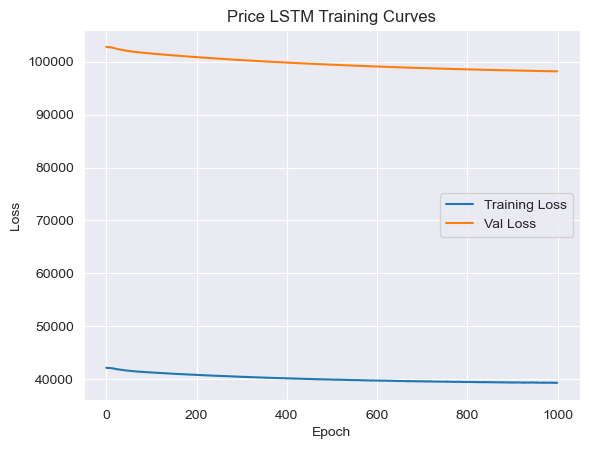

In [89]:
import matplotlib.pyplot as plt

plt.plot(train_loss_log, label = "Training Loss")
plt.plot(val_loss_log, label = "Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Price LSTM Training Curves")

Plot Predictions

Test RMSE: 313.34942057549745


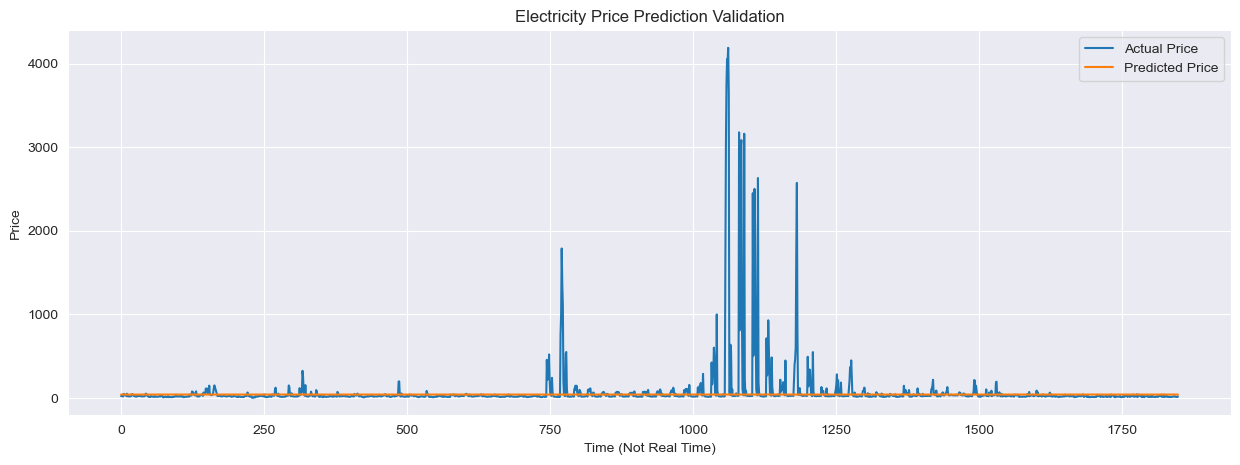

In [90]:
# Assuming 'device' is defined elsewhere in your code, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    # Move X_test to the same device as the model
    Y_test_pred = model(X_test.to(device))
    
    # Move Y_test_pred back to CPU for further operations (if necessary)
    Y_test_pred = Y_test_pred.cpu()
    
    # Assuming Y_test is a tensor, ensure it's on the CPU for comparison and plotting
    Y_test = Y_test.cpu()

# Now that Y_test_pred and Y_test are on the CPU, convert them to numpy arrays if needed
# y_test_pred_numpy = Y_test_pred.numpy()  # Only if Y_test_pred is a tensor, not necessary if it's already a numpy array
# y_test_numpy = Y_test.numpy()  # Only if Y_test is a tensor

# Calculate RMSE
rmse = np.sqrt(criterion(Y_test, Y_test_pred).item())
print(f'Test RMSE: {rmse}')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(Y_test.numpy(), label='Actual Price')  # Ensure conversion to numpy for plotting
plt.plot(Y_test_pred.numpy(), label='Predicted Price')  # Ensure conversion to numpy for plotting
plt.title('Electricity Price Prediction Validation')
plt.xlabel('Time (Not Real Time)')
plt.ylabel('Price')
plt.legend()
plt.show()

Potential future assessments:

1. Plot fitted values when using the feature vector in LSTM